# Lab 4 - Model training and experiment logging in Azure ML

In this lab you are going to train a first ML model for the german credit dataset you have just registered. Please note the following characteristics of what we are about to do:

- The ML model itself is trained using sklearn, python's most frequently used library for machine learning.
- The computation of the model will happen inside of the Compute Instance.
- The model training will be logged in an experiment in Azure ML
- The final model will be registered in Azure ML


## Connect to AML workspace & access data

In [1]:
from azureml.core import Workspace, Dataset

ws = Workspace.from_config()

print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep = '\n')

WARNING - Warning: Falling back to use azure cli login credentials.
If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


aml_test
jrie_test
westeurope
823af982-da0d-47e1-8124-3c00e4053556


## Retrieve dataset

In the following cell we are now going to retrieve the dataset we have previously registered. Note the seamless manner with which this happens. In the role of the data scientist, we don't need to know whether this data is stored, nor what account details must be used to access it. This is all abstracted by the Azure ML datasets. 

Using the *version* parameter, we can specify which version of the datset we wish to fetch. The version history is available through the python SDK but also in the Azure ML studio portal.

Once the dataset object is instantiated, we then apply the *to_pandas_dataframe* method to it to turn it into a pandas dataframe which you can then use like any other pandas dataframe you have previously worked with.

In [2]:
dataset = Dataset.get_by_name(ws, name='german_credit_dataset', version = "latest")
ds_df = dataset.to_pandas_dataframe()
ds_df.head()

,Sno,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NA,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NA,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


## Data visualization

The following cell creates a scatter plot that compares credit amounts with age of the people requesting the credit.

Feel free to experiment with other plots to familiarize yourself with the data.

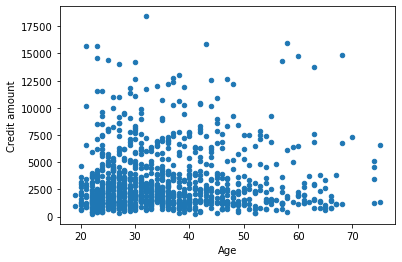

In [3]:
import matplotlib.pyplot as plt

ds_df.plot(kind='scatter', x='Age', y='Credit amount')
plt.show()

array([<AxesSubplot:title={'center':'bad'}>,
       <AxesSubplot:title={'center':'good'}>], dtype=object)

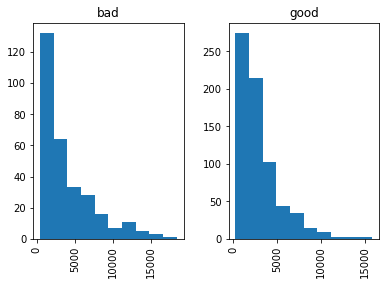

In [4]:
ds_df.hist(column = 'Credit amount', by = 'Risk')

## Train model

Next, we are going to train a ML model to predict the *Risk* variable in our dataset. In essence, this will try to learn a system that can predict for a given set of input parameters whether a credit request is likely to be paid back or not.

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

ds_df.drop("Sno", axis=1, inplace=True)

y_raw = ds_df['Risk']
X_raw = ds_df.drop('Risk', axis=1)

categorical_features = X_raw.select_dtypes(include=['object']).columns
numeric_features = X_raw.select_dtypes(include=['int64', 'float']).columns

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value="missing")),
    ('onehotencoder', OneHotEncoder(categories='auto', sparse=False))])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

feature_engineering_pipeline = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ], remainder="drop")

# Encode Labels
le = LabelEncoder()
encoded_y = le.fit_transform(y_raw)

Before training the model, we split our dataset into training and testing subsets and then create a sklearn pipeline that will combine the pre-processing steps from before with the training step.

In [6]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_raw, encoded_y, test_size=0.20, stratify=encoded_y, random_state=42)

# Create sklearn pipeline
lr_clf = Pipeline(steps=[('preprocessor', feature_engineering_pipeline),
                         ('classifier', LogisticRegression(solver="lbfgs"))])

We are using Azure ML's experiments functionality to keep track of all the models we trained as well as some of the important metrics we want to track. Here, we choose to tracking the model's accuracy on both the training and testing datasets. We could of course add other stuff to be tracked for our experiment run, e.g. the name of the algorithm that was used to train the model.

Once this code cell has completed, head over to the *Experiments* sections in your [Azure ML studio](https://ml.azure.com) environment and look for your experiment as well as the tracked metrics.

In [7]:
from azureml.core import Experiment

experiment_name = 'german_credit_data_local'
experiment = Experiment(ws, experiment_name)

run = experiment.start_logging()

# Train the model
lr_clf.fit(X_train, y_train)

# Capture metrics
train_acc = lr_clf.score(X_train, y_train)
test_acc = lr_clf.score(X_test, y_test)
print("Training accuracy: %.3f" % train_acc)
print("Test data accuracy: %.3f" % test_acc)

# Log to Azure ML
run.log('Train accuracy', train_acc)
run.log('Test accuracy', test_acc)
    
run.complete()

Training accuracy: 0.745
Test data accuracy: 0.735


Next, we will download the trained model in a serialized format (using pickle) and then upload it as an attachment to the experiment run in Azure ML. 

In [8]:
import joblib

joblib.dump(value=lr_clf, filename='model.pkl')

# Upload our model to our experiment
run.upload_file(name = 'outputs/model.pkl', path_or_stream = './model.pkl')

## Register model

Another central piece of functionality in Azure ML is its model repository. Here we can register, version and manage trained models across projects. 

The following code cell with register our model. Once the cell has completed running, again head over to the  [Azure ML studio](https://ml.azure.com) and navigate to the *Models* page to see the model listed there. Note that here again we can add meta data tags. 

When clicking the model in the list of all models, a detail page will open. These page serves as the starting point for traceability where you can see what Run ID was used to create the model. You can jump to that particular Run ID to then see the code that was used to train the model, which user trained the model, what dataset was used etc.

In [9]:
model = run.register_model(model_name='german-credit-local-model',
                           model_path='outputs/model.pkl',
                           datasets=[['training-dataset',dataset]],
                           tags={"use": "demo"})

If you wish to see how new model versions are created, re-submit your experiment and execute all the code up until model registration again. In the portal, you will then see a 2nd model listed.

## Calculate Model Explaination

Model explainations are very useful to improve ML models but also to help identify potential issues with your model, e.g. with regards to ethics.

The following code cell will create a model explanation and attached it to your experiment run. To access it, wait for the code below to finish running - which will take a couple of minutes - and then again open your experiment in the Azure ML Studio and jump to the *Explanations (Preview)* section of the page. Take some minutes to play around with the explanation dashboard shown there.

In [ ]:
# Explain model
from azureml.interpret import ExplanationClient
from azureml.core.run import Run
from interpret.ext.blackbox import TabularExplainer

client = ExplanationClient.from_run(run)

explainer = TabularExplainer(lr_clf.steps[-1][1], 
                             initialization_examples=X_train, 
                             features=X_raw.columns, 
                             classes=["Good", "Bad"], 
                             transformations=feature_engineering_pipeline)

# explain overall model predictions (global explanation)
global_explanation = explainer.explain_global(X_test)

# Sorted SHAP values
print('ranked global importance values: {}'.format(global_explanation.get_ranked_global_values()))
# Corresponding feature names
print('ranked global importance names: {}'.format(global_explanation.get_ranked_global_names()))
# Feature ranks (based on original order of features)
print('global importance rank: {}'.format(global_explanation.global_importance_rank))

client = ExplanationClient.from_run(run)
client.upload_model_explanation(global_explanation, comment='global explanation: all features')


## Disclaimer

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.